# Digital Demodulation of RAW signal

All the notation & argument naming follows Blais review paper

$$
\begin{align}
\hat{V}_{I}(t) & = V_{\text{IF}}\Big[ \hat{X}_{f}(t)\cos(\omega_{\text{IF}}t)-\hat{P_{f}}(t)\sin(\omega_{\text{IF}}t)\Big] + \hat{V}_{\text{noise},t}(t) \\ \\
\hat{V}_{Q}(t) & = -V_{\text{IF}}\Big[ \hat{P}_{f}(t)\cos(\omega_{\text{IF}}t)+\hat{X_{f}}(t)\sin(\omega_{\text{IF}}t)\Big] + \hat{V}_{\text{noise},t}(t)

\end{align}
$$

$$
\begin{equation}
\hat{X}_f = \frac{\hat{a}^\dagger_f + \hat{a}_f}{2}, 
\quad 
\hat{P}_f = \frac{i(\hat{a}^\dagger_f - \hat{a}_f)}{2},
\end{equation}
$$

$$
\begin{bmatrix}
X_{f}(t) \\
P_{f}(t)
\end{bmatrix}
= R^{-1}(t)
\begin{bmatrix}
V_{I}(t) \\
V_{Q}(t)
\end{bmatrix} 

$$

In [4]:
import numpy as np
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup


# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"],
#     number_data_qubits=1,
#     multiplex=True,
#     number_multiplex=1,
#     include_cr_lines=True,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = False,
#     filename="KAIST",
#     ip_address="192.168.0.83"
# )


# #descriptor
# setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
# #setup
# setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
# #setup.instruments




# changed to KRISS setting 0911
descriptor = generate_descriptor(
    #pqsc=[""], # 장비 여러개 사용시
    shfqc_6=["DEV12256"],
    number_data_qubits=5,
    multiplex=True,
    number_multiplex=5,
    include_cr_lines=True,
    include_ef_lines=True,
    get_zsync=False,  # Only set to True when using real device
    save = True,
    filename="TG_KAIST",
    ip_address="192.168.0.83"
)


#descriptor
setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments

In [5]:
from qpu_types import TransmonQubit, TransmonQubitParameters
from helper import load_qubit_parameters, save_qubit_parameters
from operations import TransmonOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform


#1 Create Initial QuantumElement
#qubits = TransmonQubit.from_device_setup(setup) # Also can be done with load_qubit_parameters 

#2 Load existing QuantumElement
_loaded_qubits = load_qubit_parameters(filename="latest") 
qubits = list(_loaded_qubits.values())



qpu = QPU(quantum_elements=qubits, quantum_operations=TransmonOperations())
#quantum_platform = QuantumPlatform(setup=setup, qpu=qpu)

# qpu.topology.add_edge("bus", "q16", "q17")
# qpu.topology.add_edge("bus", "q17", "q18")
# qpu.topology.add_edge("bus", "q18", "q19")
# qpu.topology.plot()


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store") 
folder_store.activate()
#folder_store.deactivate()
#workflow.logbook.LoggingStore().activate()
#workflow.logbook.LogbookStore().deactivate()


In [6]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=True, do_emulation=False)
#session.disconnect()

[2025.11.11 13:36:04.081] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /home/yalgaeahn/JSAHN/qubit-experiment/examples/laboneq_output/log
[2025.11.11 13:36:04.082] INFO    VERSION: laboneq 2.61.0
[2025.11.11 13:36:04.083] INFO    Connecting to data server at 192.168.0.83:8004
[2025.11.11 13:36:04.134] INFO    Connected to Zurich Instruments LabOne Data Server version 25.07.0.507 at 192.168.0.83:8004
[2025.11.11 13:36:04.182] INFO    Configuring the device setup
[2025.11.11 13:36:04.222] INFO    The device setup is configured


# Dispersive Shift

In [ ]:
from experiments import dispersive_shift

#######################################################################
q = qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.drive_lo_frequency = 4.6e9
temp_pars.readout_length = 0.8e-6
temp_pars.readout_integration_length = 1.0e-6
temp_pars.readout_resonator_frequency = 6.921e9 #q e 일때 res freq으로
temporary_parameters[q.uid] = temp_pars

print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = dispersive_shift.experiment_workflow.options()
options.update(False)
#print(workflow.show_fields(options))

###################################################################
dispersive = dispersive_shift.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=q.parameters.readout_resonator_frequency + np.linspace(-4e6,4e6,51),
    options=options,
    states='gef',
    temporary_parameters=temporary_parameters
)

dispersive_result = dispersive.run()
print(dispersive_result.tasks['analysis_workflow'].output)

# Params

In [93]:
#iq blob + traj

r_length = 0.8e-6
ri_length = 1.0e-6
r_f = 6.9211e9

# temp_pars.drive_range = -5
# temp_pars.drive_lo_frequency = 4.6e9
# temp_pars.spectroscopy_length = 2.0e-6
# temp_pars.spectroscopy_amplitude = 0.1
# temp_pars.readout_amplitude = 0.4
# temp_pars.readout_length = 0.8e-6
# temp_pars.readout_integration_length = 1.0e-6
# temp_pars.readout_resonator_frequency = 6.921e9 #q e 일때 res freq으로


# IQ Blobs

AcquisitionType : INTEGRATION 
AveragingMode : SINGLESHOT

In [104]:

from laboneq_applications.experiments import iq_blobs

#######################################################################
q = qubits[2]

temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.readout_resonator_frequency = r_f
temp_pars.drive_lo_frequency = 4.6e9
temp_pars.readout_length = r_length
temp_pars.readout_integration_length = ri_length

temporary_parameters[q.uid] = temp_pars
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = iq_blobs.experiment_workflow.options()

#print(workflow.show_fields(options))

###################################################################
iq = iq_blobs.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    states='gef',
    temporary_parameters=temporary_parameters
)

iq_blob_result = iq.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(iq_blob_result.tasks['analysis_workflow'].output)


DRIVE range (dBm) : -5, READOUT range (dBm) : -25
[2025.10.16 22:52:21.406] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.16 22:52:21.406] INFO      Workflow 'iq_blobs': execution started at 2025-10-16 13:52:21.405874Z         
[2025.10.16 22:52:21.406] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.16 22:52:21.416] INFO    Task 'temporary_qpu': started at 2025-10-16 13:52:21.415738Z
[2025.10.16 22:52:21.417] INFO    Task 'temporary_qpu': ended at 2025-10-16 13:52:21.417191Z
[2025.10.16 22:52:21.419] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-10-16 
[2025.10.16 22:52:21.420] INFO    13:52:21.419525Z
[2025.10.16 22:52:21.420] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-10-16 13:52:21.420427Z
[2025.10.16 22:52:21.421] INFO    Task 'create_experiment': started at 2025-10-16 13:52:21.421309Z
[2025.10.16 22:52:21.427] INFO    Task 'create_expe

In [165]:
# from laboneq.simple import show_pulse_sheet
# from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# show_pulse_sheet(compiled_experiment=iq_blob_result.tasks["compile_experiment"].output,name='test', interactive=True, max_events_to_publish=10000)


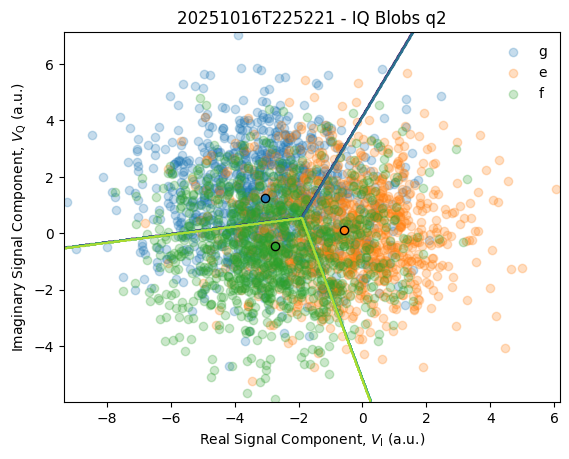

In [172]:
iq_blob_result.tasks["analysis_workflow"].tasks["plot_iq_blobs"].output["q2"]

In [ ]:

wtf=iq_blob_result.tasks["analysis_workflow"].tasks["collect_shots"].output['q2']
print(np.mean(wtf['shots_per_state']['g']))
print(np.mean(wtf['shots_per_state']['e']))
print(np.mean(wtf['shots_per_state']['f']))
ground = iq_blob_result.output['q2']['cal_trace']['g'].data
excited = iq_blob_result.output['q2']['cal_trace']['e'].data
eexcited = iq_blob_result.output['q2']['cal_trace']['f'].data

ground_c = np.mean(ground)
excited_c = np.mean(excited)
eexcited_c = np.mean(eexcited)
print(ground_c)
print(excited_c)
print(eexcited_c)

(-3.0639625443382768+1.2633743939803481j)
(-0.5747990155647045+0.10280260175901246j)
(-2.728934517607094-0.4569680500150769j)
(-3.0639625443382768+1.2633743939803481j)
(-0.5747990155647045+0.10280260175901246j)
(-2.728934517607094-0.4569680500150769j)


In [190]:
np.mean(ground.imag)

np.float64(1.2633743939803481)

# IQ Traj



To plot trajectory 
AcquisitionType : RAW   
AveragingMode : cyclic



#### Readout Pulse Shaping

rise and fall time $\tau_r$  
- $\tau_r \gg 1/\kappa$  $\implies$ adiabatic  
- $\tau_r \le 1/\kappa$  $\implies$ non-adiabatic

일반적인 steady state discrimination 이 목표라면 $\tau_r \approx 3 \sim 5 /\kappa$  


의도적으로 non-adiabatic regime 에서 fast readout도 가능

In [156]:
from experiments import iq_traj

####################################################################################
q=qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
# temp_pars.readout_amplitude = 0.4

# temp_pars.readout_integration_delay = 200e-9
temp_pars.drive_lo_frequency = 4.6e9
temp_pars.readout_resonator_frequency = r_f
temp_pars.readout_length = r_length
temp_pars.readout_integration_length = ri_length
temporary_parameters[q.uid] = temp_pars
#######################################################################
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
pprint(q.readout_parameters())
#######################################################################
options = iq_traj.experiment_workflow.options()
options.count(1024*6)
options.do_analysis(False)


#print(workflow.show_fields(options))

###################################################################
iq_t = iq_traj.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    states='gef',
    temporary_parameters=temporary_parameters
)

iq_traj_result = iq_t.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
#print(iq_result.tasks['analysis_workflow'].output)

DRIVE range (dBm) : -5, READOUT range (dBm) : -25
('measure',
 {'amplitude': 0.4,
  'length': 1e-06,
  'pulse': {'function': 'GaussianSquare',
            'risefall_sigma_ratio': 3.0,
            'sigma': 0.2}})
[2025.10.16 23:10:11.323] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.16 23:10:11.324] INFO      Workflow 'iq_traj': execution started at 2025-10-16 14:10:11.323725Z          
[2025.10.16 23:10:11.324] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.16 23:10:11.336] INFO    Task 'temporary_qpu': started at 2025-10-16 14:10:11.336666Z
[2025.10.16 23:10:11.338] INFO    Task 'temporary_qpu': ended at 2025-10-16 14:10:11.337986Z
[2025.10.16 23:10:11.341] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-10-16 
[2025.10.16 23:10:11.341] INFO    14:10:11.341109Z
[2025.10.16 23:10:11.341] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-10-16 14:10

In [157]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

#show_pulse_sheet(compiled_experiment=iq_traj_result.tasks["compile_experiment"].output,name='test', interactive=True, max_events_to_publish=10000)


- For $2\mu s$ acquire we have  2000ns/0.5ns=4000 sample

In [158]:
g_raw = iq_traj_result.output.data['q2']['cal_trace']['g'].data
e_raw = iq_traj_result.output.data['q2']['cal_trace']['e'].data
f_raw = iq_traj_result.output.data['q2']['cal_trace']['f'].data


I_f = f_raw.real
Q_f = f_raw.imag

I_e = e_raw.real
Q_e = e_raw.imag

I_g = g_raw.real
Q_g = g_raw.imag



axis = iq_traj_result.output.data['q2']['cal_trace']['g'].axis[0]

# Helper function for RAW data processing
Helper function should be designed 

Processing starts with raw complex data  (I_component, Q_component) 

1. separate I, Q signal

2. demoulate signal with IF frequency, IF_freq = target_freq - LO_freq  
    ex) IF = Transmon.drive_frequency_ge





In [208]:
def IF_demodulation(I_data, Q_data, IF_freq):

    I_data = np.array(I_data)
    Q_data = np.array(Q_data)

    coswt = np.cos(2 * np.pi * IF_freq * np.arange(len(I_data))/2 * 1e-9) # reason of 2 ; 2GHz sampling rate
    sinwt = np.sin(2 * np.pi * IF_freq * np.arange(len(Q_data))/2 * 1e-9) 

    # demodulate the data
    I_demod = I_data * coswt + Q_data * sinwt
    Q_demod = -I_data * sinwt + Q_data * coswt

    return I_demod, Q_demod

def get_avg_traj(signal, axis, avg_pts):
    signal_len = len(signal)
    _axis = np.array_split(axis, signal_len//avg_pts) 
    _signal = np.array_split(signal,signal_len//avg_pts)
    chunk_avg_signal = np.array([chunk.mean() for chunk in _signal])
    chunk_avg_axis = np.array([chunk.mean() for chunk in _axis])
    return chunk_avg_signal*signal_len, chunk_avg_axis


def get_avg_traj2(signal, axis, avg_pts):
    data_len=len(signal)
    num_avg_pts = data_len // avg_pts

    chunk_avg_signal = [np.mean(signal[i:i+avg_pts])*data_len for i in range(0, len(signal), avg_pts) ]

    time = np.linspace(0, data_len/2 -data_len/2/num_avg_pts, num_avg_pts)
    return chunk_avg_signal, time


In [209]:
readout_IF_freq = r_f- qubits[2].parameters.readout_lo_frequency
print(readout_IF_freq*1e-6)


-78.89999999999999


In [161]:
X_g, P_g = IF_demodulation(I_g, Q_g, readout_IF_freq)
X_e, P_e = IF_demodulation(I_e, Q_e, readout_IF_freq)
X_f, P_f = IF_demodulation(I_f, Q_f, readout_IF_freq)



# diff_X = X_e - X_g #I
# diff_P = P_e - P_g #Q

In [211]:
len(X_e)

2000

In [212]:
samples=iq_traj_result.output.data['q2']['cal_trace']['g'].axis[0]/ 2.0
javg_X_g, time = get_avg_traj2(X_g,samples,16)
javg_X_e, _ = get_avg_traj2(X_e,samples,16)
javg_X_f,_ = get_avg_traj2(X_f,samples,16)
javg_P_g, _ = get_avg_traj2(P_g,samples,16)
javg_P_e, _ = get_avg_traj2(P_e,samples,16)
javg_P_f, _ = get_avg_traj2(P_f,samples,16)

In [213]:
samples=iq_traj_result.output.data['q2']['cal_trace']['g'].axis[0]/ 2.0
avg_X_g,time = get_avg_traj(X_g,samples,16)
avg_X_e,_ = get_avg_traj(X_e,samples,16)
avg_X_f,_ = get_avg_traj(X_f,samples,16)

avg_P_g,time = get_avg_traj(P_g,samples,16)
avg_P_e,time = get_avg_traj(P_e,samples,16)
avg_P_f,time = get_avg_traj(P_e,samples,16)



In [214]:
len(time)


len(javg_P_e)

125

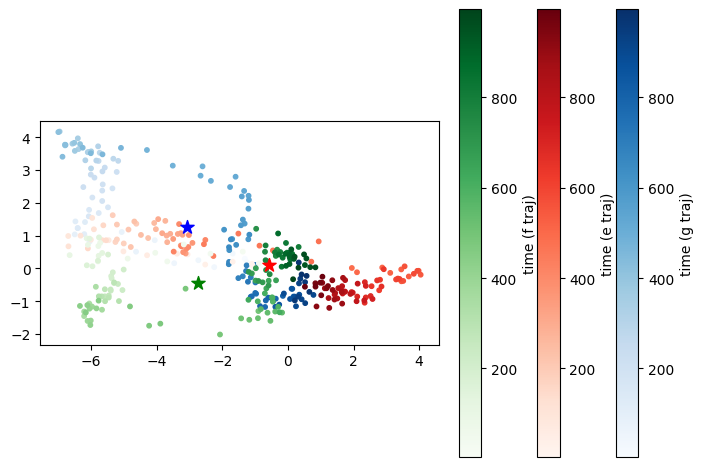

In [216]:
import matplotlib.pyplot as plt
import matplotlib as mpl


fig, ax1, = plt.subplots(constrained_layout=True)
sc1 = ax1.scatter(javg_X_g, javg_P_g, c=time, s=10, cmap="Blues")
#l1 = ax1.plot(avg_X_e[:50], avg_P_e[:50])
sc2 = ax1.scatter(javg_X_e, javg_P_e, c=time, s=10, cmap="Reds")
sc3 = ax1.scatter(javg_X_f, javg_P_f, c=time, s=10, cmap="Greens")
ax1.scatter(ground_c.real,ground_c.imag,s=100, marker="*",color='b')
ax1.scatter(excited_c.real, excited_c.imag,s=100, marker="*",color='r')
ax1.scatter(eexcited_c.real, eexcited_c.imag,s=100, marker="*",color='g')
norm = mpl.colors.Normalize(vmin=time.min(), vmax=time.max())

#cbar.set_ticks()

fig.colorbar(sc1, ax=ax1,norm=norm,label="time (g traj)")
fig.colorbar(sc2, ax=ax1,norm=norm, label="time (e traj)")
fig.colorbar(sc3, ax=ax1,norm=norm, label="time (f traj)")
ax1.set_aspect("equal", adjustable="box")


plt.show()



# Time Trace

In [61]:
from laboneq_applications.experiments import time_traces

q=qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.readout_amplitude = 0.4
temp_pars.drive_lo_frequency = 4.6e9
temp_pars.readout_length = 0.8e-6
temp_pars.readout_integration_length=1e-6
temporary_parameters[q.uid] = temp_pars
#######################################################################
pprint(q.readout_parameters())
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")

cf = 100e6
#######################################################################
options = time_traces.experiment_workflow.options()
options.update(False)
options.filter_kernels(True)
options.filter_cutoff_frequency(cf)
options.granularity(1)

#print(workflow.show_fields(options))

###################################################################
raw_trace = time_traces.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    states='gef',
    temporary_parameters=temporary_parameters
)

raw_trace_result = raw_trace.run()
raw_trace_analysis_result = raw_trace_result.tasks['analysis_workflow'].output
print(raw_trace_analysis_result)

('measure',
 {'amplitude': 0.4,
  'length': 1e-06,
  'pulse': {'function': 'GaussianSquare',
            'risefall_sigma_ratio': 3.0,
            'sigma': 0.2}})
DRIVE range (dBm) : -5, READOUT range (dBm) : -25
[2025.10.16 22:45:22.331] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.16 22:45:22.331] INFO      Workflow 'time_traces': execution started at 2025-10-16 13:45:22.330759Z      
[2025.10.16 22:45:22.331] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.16 22:45:22.344] INFO    Task 'temporary_qpu': started at 2025-10-16 13:45:22.344592Z
[2025.10.16 22:45:22.345] INFO    Task 'temporary_qpu': ended at 2025-10-16 13:45:22.345524Z
[2025.10.16 22:45:22.347] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-10-16 
[2025.10.16 22:45:22.348] INFO    13:45:22.347625Z
[2025.10.16 22:45:22.348] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-10-16 13:45

In [62]:
# from laboneq.simple import show_pulse_sheet
# from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# show_pulse_sheet(compiled_experiment=raw_trace_result.tasks["compile_experiment"].output,name='test', interactive=True)
# plot_simulation(compiled_experiment=raw_trace_result.tasks["compile_experiment"].output)

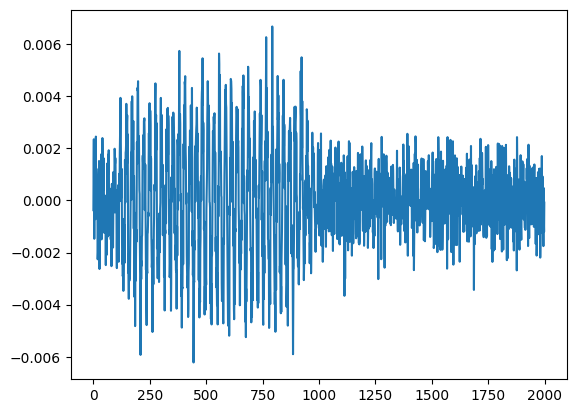

In [63]:
import matplotlib.pyplot as plt
tr_t=raw_trace_result.tasks['analysis_workflow'].tasks['truncate_time_traces'].output
#raw_trace_result.tasks['analysis_workflow'].tasks['extract_kernels_thresholds'].output

r=tr_t["q2"]


plt.plot(r[2])

In [64]:
import scipy as sp
krn=kernels
sos = sp.signal.butter(N=10, Wn=90e6,btype="lowpass", fs=2e9,output="sos")
fkrn=sp.signal.sosfiltfilt(sos, krn)

plt.plot(fkrn.real)
plt.plot(fkrn.imag)
# from analysis import time_traces
# time_traces.filter_integration_kernels(qubits=)



ValueError: The length of the input vector x must be greater than padlen, which is 33.

In [ ]:
raw_trace_result.tasks['analysis_workflow'].tasks["plot_kernels_fft"].output['q2']

In [ ]:
from laboneq_applications.analysis import time_traces
e_raw = raw_trace_result.output.data['q2']['result/e'].data
g_raw = raw_trace_result.output.data['q2']['result/g'].data

# Save Qubit Parameters

In [ ]:
from helper import load_qubit_parameters, save_qubit_parameters
save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters", filename="KRISS_last")

# Future Works on IQ related module

- iq_traj module should be integrated with iq_blobs

IQ blobs features
- double gaussian fitting for an thermal photon analysis
- confusion matrix 
- discrimination error


In [128]:
iq_traj_result.output

Results(
│   errors=[],
│   data=AttributeWrapper(
│   │   q2=AttributeWrapper(
│   │   │   cal_trace=AttributeWrapper(
│   │   │   │   e=AcquiredResult(
│   │   │   │   │   handle='q2/cal_trace/e',
│   │   │   │   │   axis_name=[
│   │   │   │   │   │   'samples'
│   │   │   │   │   ],
│   │   │   │   │   axis=[
│   │   │   │   │   │   array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.997e+03, 1.998e+03,
│      1.999e+03], shape=(2000,))
│   │   │   │   │   ],
│   │   │   │   │   data=array([-0.00080964-1.06888953e-04j, -0.00021929+5.35194415e-05j,
│      -0.00052303-2.54358948e-04j, ...,  0.00021175+5.98148338e-04j,
│   │   0.00017828+1.56612945e-03j,  0.00112596+1.05434077e-03j],
│     shape=(2000,)),
│   │   │   │   │   last_nt_step=[]
│   │   │   │   ),
│   │   │   │   f=AcquiredResult(
│   │   │   │   │   handle='q2/cal_trace/f',
│   │   │   │   │   axis_name=[
│   │   │   │   │   │   'samples'
│   │   │   │   │   ],
│   │   │   │   │   axis=[
│   │   │   │   │   │   array([0.000e+0

In [182]:
np.mean(iq_traj_result.output['q2']['cal_trace']['e'].data)



np.complex128(1.6333702633346543e-05-2.0965991320959297e-05j)

In [184]:
excited_c

np.complex128(-0.5747990155647045+0.10280260175901246j)

In [ ]:
iq_blob_result.output['q2']['cal_trace']['g'].data


array([-3.73911805+4.70933645j, -5.06585541+2.22275185j,
       -3.3007829 +5.84311293j, ..., -4.84727262+3.20530934j,
       -2.48995159+2.07994089j, -5.71255454+1.17826813j], shape=(1024,))